# Optimasi Model Deteksi Transaksi Palsu Kartu Kredit pada Data Tidak Seimbang Menggunakan SMOTE dan Random Forest

Dataset source, click [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download).

**Seiring dengan berkembangnya sistem pembayaran digital, penipuan kartu kredit juga meningkat dengan kecepatan yang sama, yang menyebabkan kerugian miliaran dolar di seluruh dunia. Situasi ini menyebabkan kerugian finansial dan reputasi yang signifikan baik bagi individu maupun lembaga keuangan.**.

Metode tradisional tidak cukup untuk mencegah penipuan kartu kredit dan digantikan oleh sistem otomatis yang lebih cerdas. Dalam proyek ini, teknik pembelajaran mesin digunakan untuk mendeteksi penipuan dengan menganalisis transaksi kartu kredit. Dataset yang digunakan dalam penelitian ini berisi transaksi yang dilakukan oleh pengguna kartu kredit di Eropa selama dua hari pada bulan September 2013.

Karena masalah privasi, variabel-variabel dalam dataset tersebut telah melalui transformasi PCA (Principal Component Analysis). Hanya variabel-variabel berikut ini yang dibiarkan dalam bentuk aslinya:

**Waktu**: Waktu yang telah berlalu sejak dimulainya transaksi.
* **Jumlah**: Jumlah transaksi.

Selain itu, variabel **Class** adalah variabel target yang mengindikasikan apakah transaksi tersebut penipuan atau bukan.  
(1: Penipuan, 0: Bukan penipuan).

> ## 1.1 Mengimpor Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC


from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, RandomUnderSampler
from imblearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore")


> ## 1.2 Mengimpor Dataset

In [2]:
## connecting to the google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_ = pd.read_csv ('/content/drive/MyDrive/creditcard.csv')
df = df_.copy()

# 2. Data Preprocessing


> ## 2.1 Exploratory Data Analysis (EDA)

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

Dataset ini berisi total 284.807 baris dan 31 kolom. Ketika kita melihat 5 baris pertama, kita dapat melihat bahwa sebagian besar kolom terdiri dari nilai numerik. Kolom 'Kelas' mewakili variabel target, yang mengindikasikan apakah transaksi tersebut penipuan (1) atau normal (0). Kolom-kolom lainnya telah ditransformasikan menggunakan Principal Component Analysis (PCA) untuk menjaga privasi data, dan sebagai hasilnya, kolom-kolom tersebut telah diubah menjadi nilai numerik.


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Variabel target, kolom 'Kelas', berisi transaksi penipuan (1) dan transaksi nonpemalsuan (0). Dengan melihat tabel, kita dapat melihat bahwa nilai rata-rata dari kolom ini adalah 0.0017, yang mengindikasikan bahwa proporsi transaksi yang curang di dalam dataset cukup rendah, dan datanya tidak seimbang. Hal ini menyoroti perlunya memperhatikan masalah ketidakseimbangan kelas selama fase pembuatan model.

Pada kolom 'Jumlah', jumlah transaksi minimum adalah 0, dan jumlah maksimumnya adalah 25.691. Kisaran jumlah transaksi yang luas dan standar deviasi yang tinggi (250.12) menunjukkan bahwa ada perbedaan yang signifikan antara transaksi. Setelah memeriksa distribusi kolom ini, kita dapat menyimpulkan bahwa penskalaan fitur akan diperlukan di tahap selanjutnya. Langkah ini sangat penting untuk meningkatkan performa model dan mendapatkan hasil yang lebih konsisten.

Kolom 'Waktu' menunjukkan waktu yang telah berlalu dalam hitungan detik sejak transaksi terjadi. Nilai minimumnya adalah 0, dan nilai maksimumnya adalah 172.792, yang mengonfirmasi bahwa dataset dikumpulkan dalam jangka waktu dua hari. Standar deviasi dari kolom ini adalah 47.488, yang mengindikasikan distribusi transaksi yang luas dari waktu ke waktu.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
df.isna().sum().sum()

0

Tidak ada nilai yang hilang (null) dalam dataset kami, yang menunjukkan bahwa kami bekerja dengan dataset yang bersih untuk analisis kami. Ini berarti tidak diperlukan langkah tambahan seperti imputasi atau pembersihan data, dan ini memungkinkan kita untuk langsung beralih ke tahap analisis dan pemodelan data.

Setelah memeriksa tipe data dari variabel-variabel tersebut, kita dapat melihat bahwa variabel 'Kelas' bertipe integer, sementara semua variabel lainnya bertipe float.

Kolom 'Waktu' berisi informasi tentang waktu transaksi dan dapat digunakan untuk menganalisis apakah transaksi penipuan lebih sering terjadi selama periode waktu tertentu. Kolom ini merupakan sumber penting untuk mengeksplorasi pola waktu transaksi, seperti jam-jam mana dalam sehari yang mengalami lebih banyak aktivitas atau apakah ada pola aktivitas penipuan dari waktu ke waktu.

Selain itu, untuk lebih memahami dimensi waktu dari dataset, kita dapat membuat fitur baru dengan mengubah kolom 'Waktu' menjadi segmen per jam atau per hari. Transformasi seperti itu dapat berkontribusi pada model yang menghasilkan hasil yang lebih bermakna dalam pendeteksian penipuan. Dengan mempertimbangkan potensi ini, kami terus menganalisis dataset secara mendetail.

In [9]:
fraud_count = df['Class'].value_counts()
fraud_count

,count
Class,
0,284315
1,492


In [10]:
print('Non-fraud: %', round(df['Class'].value_counts()[0] / len(df) * 100 , 2),
    '\nFraud: %', round(df['Class'].value_counts()[1] / len(df) * 100,2))


Non-fraud: % 99.83 
Fraud: % 0.17


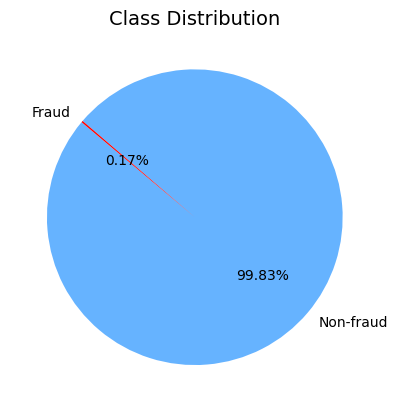

In [11]:
# Calculate the percentages of the classes
fraud_counts = df['Class'].value_counts(normalize=True)

labels = ['Non-fraud', 'Fraud']
plt.pie(fraud_counts, labels=labels, autopct='%1.2f%%', colors=['#66b3ff', 'red'], startangle=140)
plt.title('Class Distribution', fontsize=14)
plt.show()


Seperti yang sudah disebutkan sebelumnya, data dalam kolom 'Kelas' tidak seimbang. Dengan memeriksa tabel, kita dapat melihat dengan jelas hal ini. Menurut analisis, proporsi transaksi Penipuan (1) hanya **0,17%**, yang jelas menunjukkan ketidakseimbangan kelas yang signifikan dalam set data. Menggunakan dataset yang tidak seimbang ini secara langsung untuk model prediksi dan analisis dapat membuat algoritme mengasumsikan bahwa sebagian besar transaksi tidak curang, yang dapat meningkatkan risiko **overfitting**. Oleh karena itu, selama pemodelan, ketidakseimbangan ini harus diperhitungkan, dan kemungkinan penerapan teknik yang tepat untuk menyeimbangkan dataset harus dipertimbangkan.

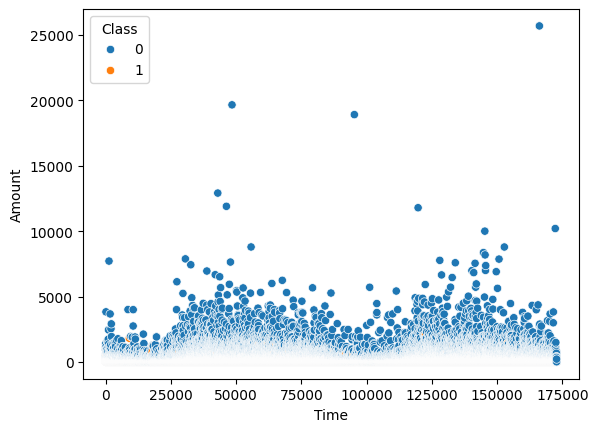

In [12]:
sns.scatterplot(data = df, x = 'Time', y = 'Amount', hue = 'Class') ;

Dari grafik, kita dapat mengamati bahwa **transaksi non-fraud (Kelas 0)** menunjukkan distribusi yang sangat padat dari waktu ke waktu. Sebagian besar transaksi ini tampaknya terkonsentrasi pada jumlah di bawah 5000. Hal ini menunjukkan bahwa perilaku pengguna pada umumnya melibatkan jumlah transaksi yang kecil dan teratur. Namun, kami juga melihat transaksi dengan jumlah yang lebih tinggi tersebar di seluruh transaksi. Secara keseluruhan, transaksi-transaksi ini secara konsisten tersebar dan padat.

**Transaksi penipuan (Kelas 1)** diwakili oleh titik oranye pada grafik. Transaksi penipuan tampak cukup jarang di sini. Hal ini menegaskan bahwa kasus penipuan jauh lebih jarang terjadi di dataset (ketidakseimbangan kelas).

Terdapat jumlah transaksi penipuan yang rendah dan tinggi. Namun, transaksi penipuan dengan jumlah tinggi ini sering terlihat di antara titik-titik biru (transaksi normal). Transaksi penipuan cenderung tumpang tindih dengan transaksi lain dari waktu ke waktu, yang berarti transaksi tersebut tampaknya tidak fokus pada periode waktu tertentu. Hal ini menunjukkan bahwa kecurangan dapat terjadi kapan saja, dan waktu mungkin bukan fitur pembeda yang signifikan untuk mendeteksi kecurangan. Oleh karena itu, alih-alih secara langsung menggunakan waktu sebagai faktor pembeda, kita mungkin perlu menganalisis pola berbasis waktu (seperti apakah ada rentang waktu tertentu di mana kecurangan lebih terkonsentrasi).

Kesimpulannya:

* Pada grafik ini, kita melihat bahwa transaksi penipuan cukup jarang dan tersebar. Hal ini memperkuat kebutuhan akan penyeimbangan data (resampling).
* Waktu dan jumlah saja mungkin tidak cukup untuk mendeteksi penipuan. Namun, jika dianalisis bersama dengan fitur lainnya, keduanya dapat memberikan wawasan yang berharga.

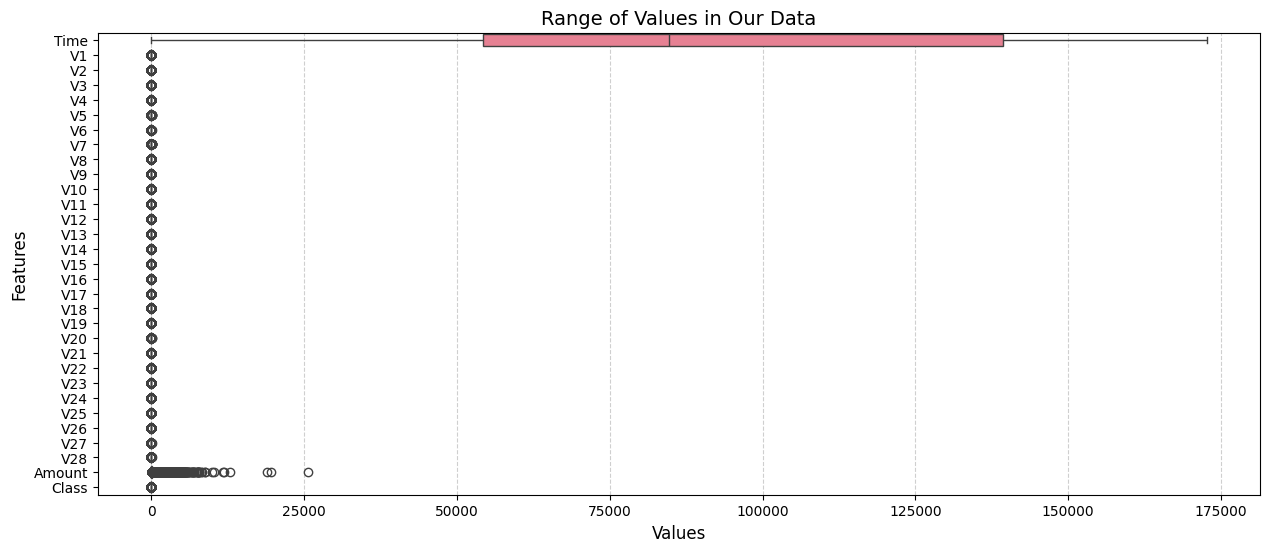

In [13]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, orient="h")
plt.title("Range of Values in Our Data", fontsize=14)
plt.xlabel("Values", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Dalam bagan ini, yang kami plot untuk memeriksa distribusi umum dari kolom-kolom kami, kita dapat melihat bahwa kolom **Waktu** dan **Jumlah** memiliki rentang nilai yang sangat berbeda dibandingkan dengan fitur-fitur lainnya. Hal ini menunjukkan bahwa dalam algoritma pembelajaran mesin berbasis jarak, rentang nilai yang besar dapat menutupi efek dari kolom lainnya. Untuk menghilangkan efek ini dan memastikan bahwa fitur-fitur berkontribusi secara merata, operasi penskalaan harus diterapkan pada kolom-kolom ini.

* Kolom **Waktu** memiliki rentang nilai terbesar, mencapai 175.000, yang mewakili keragaman yang luas dalam dimensi waktu.

* Kolom **Jumlah** juga memiliki rentang yang luas, tetapi fitur lainnya cenderung terkonsentrasi dalam rentang yang lebih sempit.

* Semua fitur lainnya hampir dikompresi di sekitar nol. Hal ini mengindikasikan bahwa jika penskalaan tidak dilakukan, kolom seperti **Waktu** dan **Jumlah** dapat membayangi fitur-fitur lain dan berpotensi mempengaruhi hasil analisis.

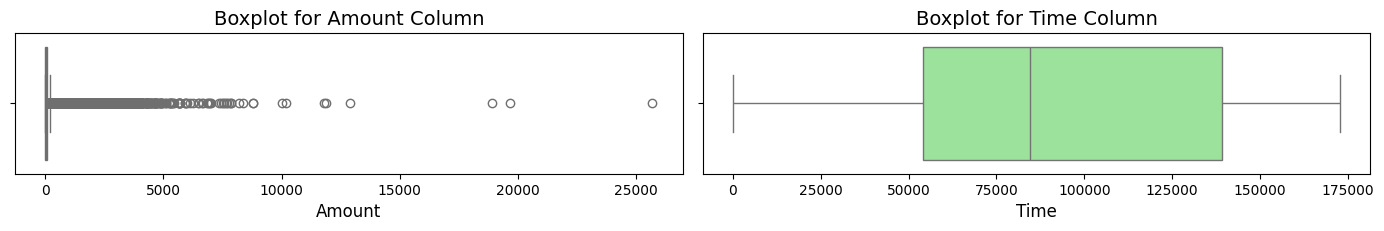

In [14]:
# Boxplot to visualize outliers in the Amount column
plt.figure(figsize=(14, 6))

plt.subplot(3, 2, 1)
sns.boxplot(x=df['Amount'], color='skyblue')
plt.title('Boxplot for Amount Column', fontsize=14)
plt.xlabel('Amount', fontsize=12)

# Boxplot to visualize outliers in the Time column
plt.subplot(3, 2, 2)
sns.boxplot(x=df['Time'], color='lightgreen')
plt.title('Boxplot for Time Column', fontsize=14)
plt.xlabel('Time', fontsize=12)

plt.tight_layout()
plt.show()


### **Kolom Jumlah:**

- Ketika kita memeriksa boxplot pertama, kita dapat mengamati bahwa kolom Jumlah memiliki rentang yang luas dan mengandung beberapa pencilan. Pencilan ini mewakili jumlah transaksi yang jarang terjadi namun sangat tinggi dalam kumpulan data.

- Sebagian besar nilai dalam grafik mengelompok di bagian bawah (kiri) boxplot, yang berarti sebagian besar jumlah transaksi relatif kecil.

Keberadaan pencilan dapat menjadi detail penting untuk mendeteksi penipuan, karena penipu sering melakukan transaksi dengan jumlah yang tidak biasa. Oleh karena itu, alih-alih menghapus pencilan ini, kita dapat mempertimbangkan untuk menskalakan data menggunakan metode seperti RobustScaler.

---
### **Kolom Waktu:**

- Ketika kita melihat boxplot kedua, kita melihat bahwa kolom Waktu memiliki distribusi yang lebih seragam. Lebar dari boxplot menunjukkan bahwa nilai pada kolom Waktu tersebar dalam rentang yang luas.

- Kolom Waktu menunjukkan durasi (dalam detik) sejak transaksi dimulai. Oleh karena itu, tidak ada nilai ekstrem yang dianggap sebagai outlier. Hal ini menunjukkan bahwa kolom Waktu adalah fitur yang lebih seimbang.

> ## 2.2 Examination of Relationships Between Variables Using Graphs


>> Waktu dengan Aktivitas Penipuan Tinggi

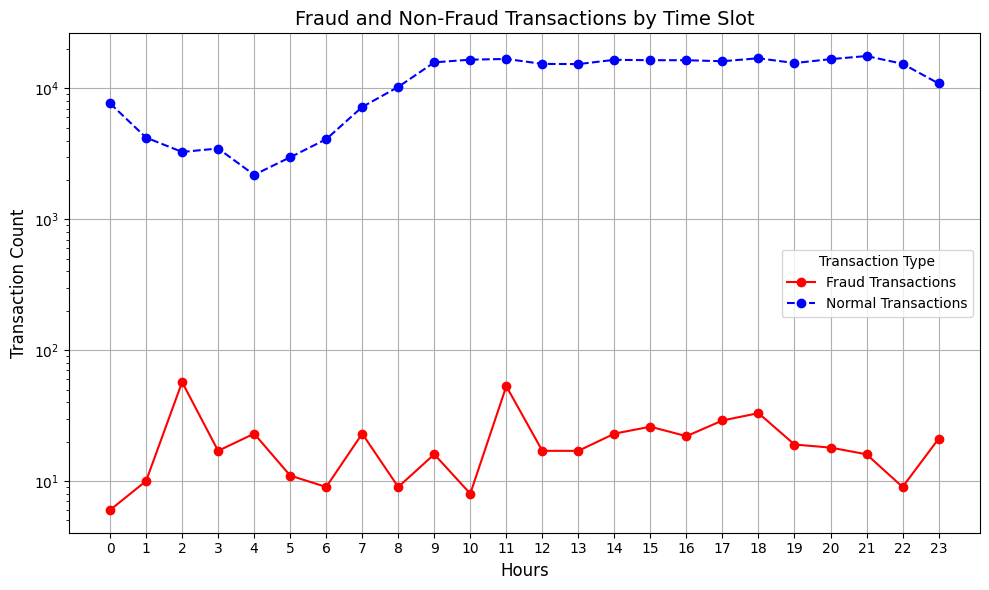

In [15]:
# Convert the 'Time' column to create time slots
hourly_data = df.copy()
hourly_data['Hour'] = pd.to_datetime(hourly_data['Time'], unit='s').dt.hour

# Grouping by time slots for fraud and non-fraud transactions
fraud_data = hourly_data[hourly_data['Class'] == 1].groupby('Hour').size()  # Fraud transactions
non_fraud_data = hourly_data[hourly_data['Class'] == 0].groupby('Hour').size()  # Non-fraud transactions

# Plotting the graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_yscale('log')  # Sets the y-axis to a logarithmic scale.

# Plot fraud transactions
ax.plot(fraud_data.index, fraud_data.values, '-o', label='Fraud Transactions', c='red')

# Plot non-fraud transactions
ax.plot(non_fraud_data.index, non_fraud_data.values, '--o', label='Normal Transactions', c='blue')

# Title and labels
ax.set_title('Fraud and Non-Fraud Transactions by Time Slot', fontsize=14)
ax.set_xlabel('Hours', fontsize=12)
ax.set_ylabel('Transaction Count', fontsize=12)

# Grid, legend, and x-axis adjustments
ax.grid(True)
plt.xticks(range(24))  # Display time slots from 0-23
plt.legend(title='Transaction Type')

# Show the plot
plt.tight_layout()
plt.show()


Dalam grafik ini, transaksi fraud dan non-fraud diperiksa berdasarkan jumlah transaksi pada jam-jam yang berbeda dalam satu hari. Karena jumlah transaksi non-fraud secara signifikan lebih tinggi daripada transaksi fraud, skala logaritmik telah digunakan untuk memvisualisasikan data dengan lebih baik. Pada skala linier, perbedaan besar antara transaksi fraud dan non-fraud dapat membuat transaksi fraud tidak terlihat. Skala logaritmik memberikan kesempatan untuk menganalisis nilai yang besar dan kecil dengan lebih jelas pada waktu yang bersamaan.

Melihat detail grafik, dapat dilihat bahwa transaksi non-fraud (garis biru) cukup sering terjadi sepanjang hari. Khususnya, dari pukul 9:00 pagi hingga 6:00 sore, terdapat puncak jumlah transaksi. Hal ini mengindikasikan bahwa pengguna cenderung melakukan lebih banyak transaksi selama jam kerja. Sementara transaksi terus berlanjut pada malam hari, terjadi penurunan volume transaksi dibandingkan dengan waktu-waktu lain dalam sehari.


Sebaliknya, transaksi penipuan (garis merah) terjadi pada frekuensi yang jauh lebih rendah. Namun, terdapat peningkatan transaksi penipuan yang nyata pada jam-jam tertentu (misalnya tengah malam, dini hari, dan makan siang). Hal ini dapat menunjukkan bahwa penipu lebih memilih jam-jam ketika mereka cenderung tidak menarik perhatian. Selain itu, peningkatan sekitar pukul 11:00 dapat mengindikasikan bahwa penipu mencoba melakukan transaksi pada saat sistem lebih aktif.

Grafik ini memberikan wawasan yang berharga tentang distribusi transaksi penipuan di berbagai jam dalam sehari, yang dapat menjadi sangat penting untuk mengoptimalkan langkah-langkah keamanan. Sebagai contoh, memperkuat sistem keamanan pada jam-jam dengan aktivitas penipuan yang tinggi atau menyempurnakan algoritme pendeteksian anomali pada jam-jam tertentu dapat membantu mencegah insiden semacam itu. Di masa depan, analisis tingkat penipuan per jam dibandingkan dengan total transaksi dapat dilakukan, dan mekanisme anti-penipuan dapat ditingkatkan dengan menggunakan data ini.



>> Pemeriksaan Jumlah Transaksi


<Axes: xlabel='Log_Amount', ylabel='Density'>

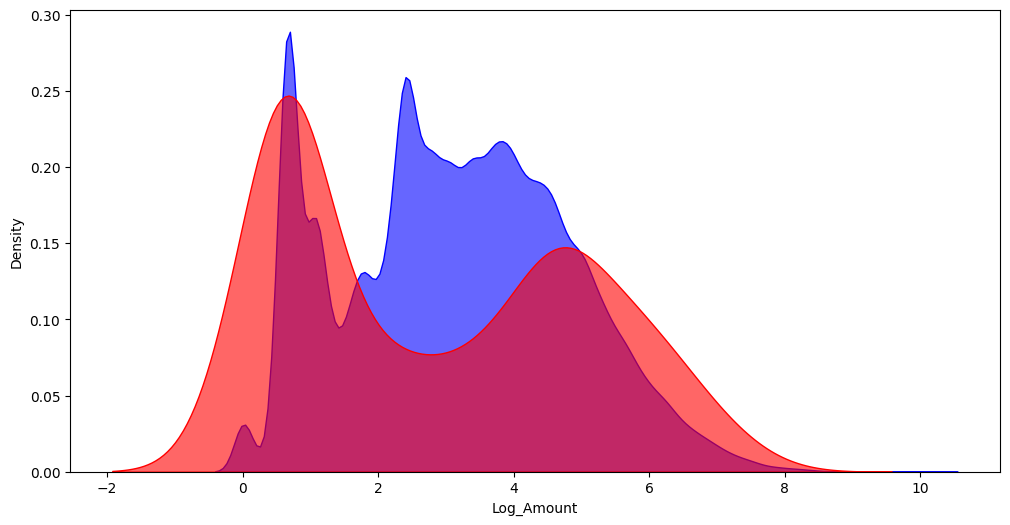

In [16]:
# Convert the data to logarithmic scale (1 is added to avoid 0 values)
df['Log_Amount'] = np.log1p(df['Amount'])  # log1p(x) = log(x + 1)

# Separate fraud and non-fraud transactions
fraud_amount = df[df['Class'] == 1]['Log_Amount']
non_fraud_amount = df[df['Class'] == 0]['Log_Amount']

# Set the figure size
plt.figure(figsize=(12, 6))

# KDE plot for Non-Fraud (Normal Transactions)
sns.kdeplot(non_fraud_amount, fill=True, color="blue", label="Normal Transactions", alpha=0.6)

# KDE plot for Fraud (Fraud Transactions)
sns.kdeplot(fraud_amount, fill=True, color="red", label="Fraud Transactions", alpha=0.6)


Dalam grafik ini, Transaksi Normal dan Transaksi Penipuan dibandingkan berdasarkan jumlah logaritmiknya. Transaksi normal memiliki distribusi yang padat antara 1 dan 5 pada skala logaritmik, sementara transaksi penipuan lebih terkonsentrasi pada jumlah yang lebih rendah. Hal ini menunjukkan bahwa penipu cenderung menguji sistem dengan jumlah yang lebih rendah, mencoba beroperasi tanpa menarik perhatian.

Grafik menunjukkan bahwa transaksi penipuan menunjukkan kepadatan yang tinggi pada kisaran 0-2 pada skala logaritmik, sementara pada kisaran 3-6, mereka tetap lebih rendah dibandingkan dengan transaksi normal. Transaksi normal, di sisi lain, mencapai puncaknya pada jumlah yang moderat dan terdistribusi pada rentang yang lebih luas. Hal ini mengindikasikan bahwa pengguna biasa melakukan transaksi dalam jumlah yang bervariasi, dan transaksi penipuan menurun pada kisaran ini.

Pada jumlah yang lebih tinggi, transaksi penipuan hampir menghilang. Hal ini menunjukkan bahwa penipu cenderung menghindari melakukan transaksi dengan jumlah yang besar.

Dari sini, dapat disimpulkan bahwa sistem pendeteksi kecurangan harus lebih memperhatikan transaksi bernilai rendah, sementara metode pemantauan yang lebih spesifik dapat digunakan untuk transaksi bernilai menengah dan tinggi.


# 3. Feature Scaling

In [17]:
# Feature Scaling
rob_scaler = RobustScaler()
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# menghapus kolom Waktu dan Jumlah
df.drop(['Time', 'Amount'], axis=1, inplace=True)

#  mengatur pengurutan kolom
columns_order = ['scaled_time', 'scaled_amount'] + [col for col in df.columns if col not in ['scaled_time', 'scaled_amount']]
df = df[columns_order]

df.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log_Amount
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.014760
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1.305626
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.939276
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.824306
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.262539


Penskalaan fitur bertujuan untuk membuat proses pembelajaran model menjadi lebih efisien. Ketika data berada dalam skala yang sama, algoritme dapat belajar lebih cepat dan lebih akurat. Oleh karena itu, kami menggunakan **RobustScaler** untuk membuat data dalam kolom **Jumlah** dan **Waktu** menjadi lebih konsisten.

Seperti yang telah kita amati sebelumnya, **outlier** dalam kolom-kolom ini menciptakan situasi yang dapat berdampak negatif pada akurasi model. **RobustScaler** menskalakan data menggunakan median dan rentang interkuartil, bukan mean dan standar deviasi. Oleh karena itu, ini memberikan hasil yang lebih baik ketika ada titik data di luar distribusi normal atau mengandung pencilan. Dampaknya yang lebih kecil terhadap pencilan memungkinkan kita untuk menskalakan data tanpa mempengaruhi akurasi model secara keseluruhan.

Hasilnya, proses penskalaan ini mengoptimalkan pembelajaran model dengan **menghilangkan dampak outlier**, sehingga menghasilkan hasil yang lebih sehat dan lebih dapat diandalkan. Selain itu, **fitur unik dalam dataset dipertahankan**, yang meningkatkan akurasi model. Jika kami menghapus atau memanipulasi pencilan, keaslian titik data ini akan terganggu, dan kinerja model akan menurun. Oleh karena itu, kami melakukan operasi penskalaan dengan tepat tanpa mengubah pencilan. Pendekatan ini meningkatkan tingkat keberhasilan model, memungkinkan prediksi yang lebih andal dan bermakna.


# 4. Solutions for Imbalanced Data


Dataset yang tidak seimbang terjadi ketika ada ketidakseimbangan yang serius dalam jumlah sampel yang termasuk dalam kelas yang berbeda. Sebagai contoh, akurasi sebuah model mungkin terlihat setinggi 95%, tetapi jika model tersebut hanya memprediksi kelas mayoritas, hal ini mengindikasikan bahwa model tersebut mengabaikan kelas minoritas. Dalam kasus seperti ini, model tidak dapat melakukan kinerja yang sebenarnya karena kelas minoritas kurang terwakili.

Untuk mengatasi masalah ini, metode seperti oversampling (meningkatkan kelas minoritas) dan undersampling (mengurangi kelas mayoritas) dapat digunakan. Pendekatan ini membantu model untuk mempelajari kedua kelas secara akurat dan memberikan prediksi yang lebih seimbang.


## **Visualization of Over Sampling and Under Sampling**


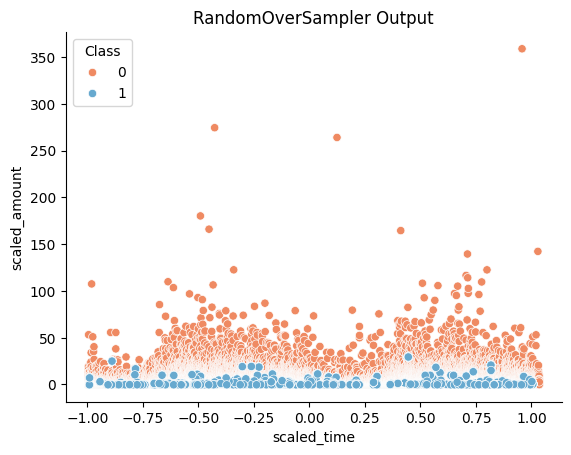

In [18]:
X = df[['scaled_time', 'scaled_amount']]
y = df['Class']

# Data preparation for Oversampling
ros = RandomOverSampler(random_state=45)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Creating DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=df.columns[:-1])  # Features from X
df_resampled['Class'] = y_resampled  # Target class from y

# Creating scatter plot
sns.scatterplot(data=df_resampled, x='scaled_time', y='scaled_amount', hue='Class', palette={0: '#ef8a62', 1: '#67a9cf'})

# Title and visualization
plt.title("RandomOverSampler Output")
sns.despine()
plt.show()


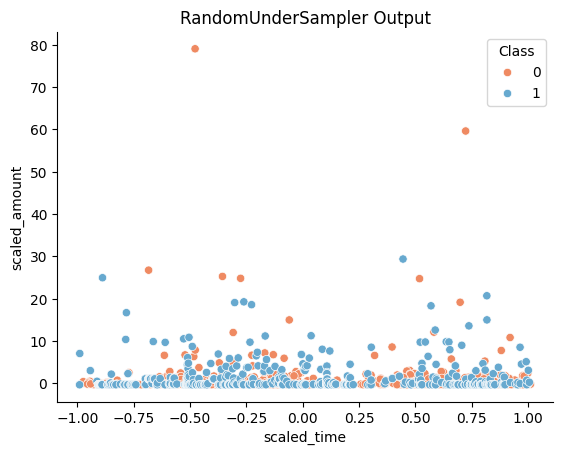

In [19]:
# Data preparation for Undersampling
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Creating DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=df.columns[:-1])  # Features from X
df_resampled['Class'] = y_resampled  # Target class from y

# Creating scatter plot
sns.scatterplot(data=df_resampled, x='scaled_time', y='scaled_amount', hue='Class', palette={0: '#ef8a62', 1: '#67a9cf'})

# Title and visualization
plt.title("RandomUnderSampler Output")
sns.despine()
plt.show()


Pada grafik pertama, ketidakseimbangan antara kelas-kelas dalam dataset diatasi dengan meningkatkan jumlah sampel kelas 'penipuan' yang jarang terjadi, untuk menyeimbangkan dataset. Hasilnya, baik transaksi penipuan maupun bukan penipuan memiliki jumlah observasi yang sama. Namun, selama proses duplikasi ini, contoh kelas penipuan diulang beberapa kali, yang dapat mengekspos model ke **data yang berlebihan** selama pelatihan. Hal ini dapat berdampak negatif pada kemampuan generalisasi model, yang mengarah pada kinerja yang buruk pada data baru.

Pada grafik kedua, ketidakseimbangan dalam dataset diatasi dengan secara acak menghapus kelebihan observasi dari kelas 'non-fraud' (transaksi normal). Dalam proses ini, jumlah observasi 'non-fraud' disamakan dengan jumlah observasi kelas 'fraud', sehingga menyeimbangkan dataset dan menghilangkan ketidakseimbangan kelas.

*Metode penyeimbangan data mana yang lebih cocok tergantung pada besarnya ketidakseimbangan dalam dataset dan jumlah sampel dalam kelas 'penipuan'. Tujuan keseluruhan di sini adalah untuk meningkatkan akurasi model secara umum dan mengurangi efek dari data yang tidak seimbang.*


> ## 4.1 Logistic Regression with Imbalanced Data


In [20]:
# Selecting features and target variable
X = df.drop(columns=['Class'])  # All columns except the class to be predicted
y = df['Class']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [21]:
# Logistic Regression model
logistic_model = LogisticRegression(max_iter=6000, solver='saga')
logistic_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = logistic_model.predict(X_test)

In [22]:
accuracy = logistic_model.score(X_train, y_train)
print(f"Model accuracy score = {accuracy}")

Model accuracy score = 0.9991723681306555


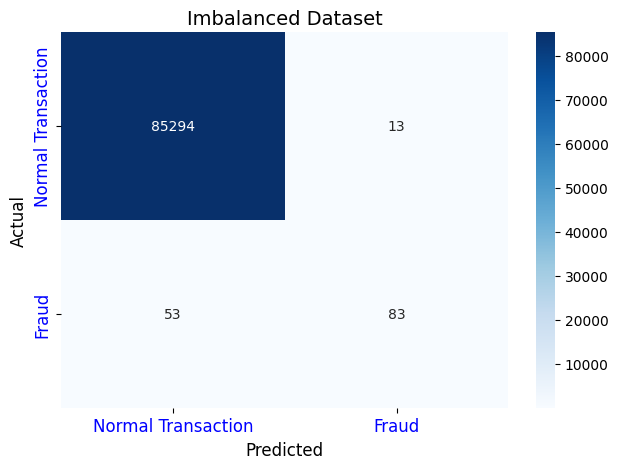

In [23]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    # Labels for the axes
    class_names = ['Normal Transaction', 'Fraud']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(title, fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    plt.xticks(fontsize=12, color="blue")
    plt.yticks(fontsize=12, color="blue")

    plt.tight_layout()
    plt.show()

# Drawing the plot
plot_confusion_matrix(y_test, y_pred, "Imbalanced Dataset")

* Untuk transaksi non-fraud, 83.294 (TP) prediksi benar dan 13 (FP) salah, dengan total 85.307 prediksi.
* Untuk kelas penipuan, 53 (FN) prediksi salah dan 83 (TN) prediksi benar, dengan total 136 prediksi.


Kami melihat bahwa nilai akurasi model kami mencapai **0,9992**, yang sekilas tampak seperti hasil yang sangat baik. Namun, ini adalah metrik yang menyesatkan karena dataset kami tidak seimbang. Hal ini menjadi lebih jelas ketika kita memeriksa **Confusion Matrix**.

Bahkan jika model salah mengklasifikasikan transaksi penipuan, model ini mencapai tingkat akurasi yang tinggi dengan memprediksi kelas mayoritas dengan benar, yaitu transaksi non-fraud. Hal ini mengindikasikan bahwa model ini **berhasil memprediksi kelas mayoritas**, namun **berkurang dalam memprediksi kelas minoritas**. Singkatnya, model kami mengklasifikasikan kelas non-fraud dengan benar dengan tingkat akurasi 99%, tetapi gagal dalam memprediksi kelas fraud.

Oleh karena itu, **akurasi** saja bukanlah metrik yang cukup untuk mengevaluasi kinerja dalam set data yang tidak seimbang. Untuk mendapatkan evaluasi yang lebih seimbang dan bermakna, metrik seperti presisi, recall, dan f1-score harus digunakan.



In [24]:
logistic_model.score(X_train,y_train)
print("Results of Imbalanced Dataset:")
print(classification_report(y_test, y_pred, target_names=['Non-fraud','Fraud']))


Results of Imbalanced Dataset:
              precision    recall  f1-score   support

   Non-fraud       1.00      1.00      1.00     85307
       Fraud       0.86      0.61      0.72       136

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



**Ketepatan mengukur seberapa akurat prediksi positif yang dibuat oleh model. Dengan kata lain, ini dapat didefinisikan sebagai “**persentase transaksi yang diprediksi sebagai penipuan yang sebenarnya adalah penipuan**.”
* Model ini mengklasifikasikan **transaksi non-fraud** dengan akurasi 100%, sedangkan presisi untuk **transaksi fraud** adalah 86%. Ini berarti 86% dari transaksi yang diprediksi sebagai penipuan adalah benar-benar penipuan, tetapi 14% sisanya salah diprediksi.

**Recall** mengukur seberapa baik model mendeteksi contoh-contoh positif. Hal ini menjawab pertanyaan, “**Berapa banyak dari transaksi penipuan yang sebenarnya yang berhasil kita identifikasi dengan benar?”
* Model ini mendeteksi **transaksi non-fraud** dengan akurasi 100%. Namun, recall untuk **transaksi penipuan** adalah 61%. Hal ini mengindikasikan bahwa 39% dari transaksi penipuan salah diklasifikasikan oleh model sebagai “bukan penipuan”. **Rendahnya recall menunjukkan bahwa model ini kesulitan untuk mendeteksi penipuan.**.


**F1-score** adalah metrik yang mengukur keseimbangan antara presisi dan recall. Metrik ini digunakan sebagai metrik kinerja yang lebih andal dalam set data yang tidak seimbang.
* Nilai **F1-score** untuk **transaksi non-fraud** adalah 1.00, yang mengindikasikan bahwa model berkinerja sangat baik di kelas ini. Namun, untuk **transaksi penipuan**, nilai F1-skor turun menjadi 0,72. Hal ini disebabkan oleh presisi dan recall yang lebih rendah untuk kelas penipuan. Model ini memiliki keberhasilan yang terbatas dalam mendeteksi penipuan.

**Analisis ini menunjukkan bahwa meskipun model mengklasifikasikan transaksi non-fraud dengan sangat baik, model ini mengalami kesulitan untuk mendeteksi transaksi fraud. Secara khusus, recall yang rendah untuk transaksi penipuan (61%) menunjukkan bahwa model gagal dalam banyak kasus, yang mengarah ke tingkat negatif palsu yang tinggi. Oleh karena itu, perlu menggunakan teknik penyeimbangan data untuk meningkatkan kinerja model dan mengatasi masalah dataset yang tidak seimbang.**


## RESAPMLING

**Resampling adalah teknik yang digunakan untuk membuat set data yang tidak seimbang menjadi lebih seimbang. Proses ini dilakukan dengan **menambahkan contoh baru ke kelas minoritas (oversampling)** atau **menghapus beberapa contoh dari kelas mayoritas (undersampling)**. Dengan cara ini, model dapat **belajar lebih baik untuk kedua kelas**.

Sekarang, kita akan menyeimbangkan dataset kita dengan menggunakan metode resampling dan memeriksa bagaimana metode ini mempengaruhi kinerja model kita. Pada tahap pertama, kita akan menggunakan **Regresi Logistik** karena metode ini berbiaya rendah dan mudah diimplementasikan. Metode ini akan memberikan kami **wawasan cepat mengenai efek dari dataset dan teknik resampling**. Berdasarkan hasil yang didapat, kami berencana untuk mengoptimalkan kinerja dengan memilih **algoritma pembelajaran mesin yang paling sesuai** untuk kebutuhan dataset kami.


![](http://blog.talent500.co/wp-content/uploads/2024/05/images-21-3.png)

> ## 4.2 Logistic Regression with Oversampling

In [25]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

unique, count =np.unique(y_train_smote, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{0: 199008, 1: 199008}

In [26]:
model_smote = LogisticRegression(solver='saga', max_iter=6000, random_state=42)
model_smote.fit(X_train_smote, y_train_smote)


y_pred_smote = model_smote.predict(X_test)

In [27]:
accuricy_smote = model_smote.score(X_train_smote,y_train_smote)
print (f"Skor akurasi model= {accuricy_smote}")

Skor akurasi model= 0.9470197178002895


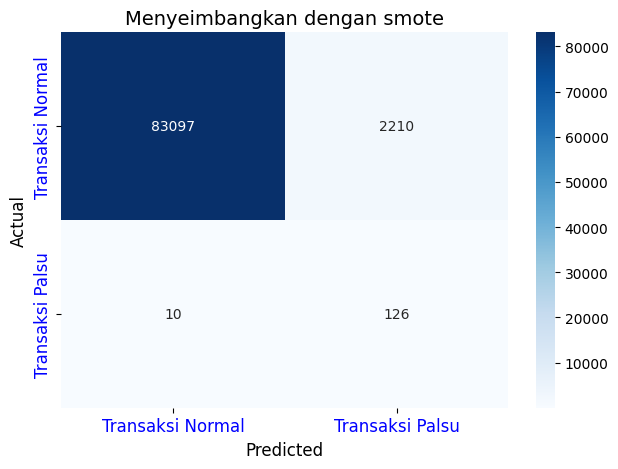

In [28]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    # Label
    class_names = ['Transaksi Normal', 'Transaksi Palsu']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(title, fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    plt.xticks(fontsize=12, color="blue")
    plt.yticks(fontsize=12, color="blue")

    plt.tight_layout()
    plt.show()

# Gambar Grafik
plot_confusion_matrix(y_test, y_pred_smote, "Menyeimbangkan dengan smote")


* Untuk transaksi non-fraud, 83.097 (TP) benar, 2.210 (FP) salah, total 85.307 prediksi dibuat.
* Untuk kelas penipuan, 10 (FN) salah, 126 (TN) benar, total 136 prediksi dibuat.


Ketika bekerja dengan dataset yang tidak seimbang, akurasi model kami sangat tinggi, yaitu 99%. Namun, akurasi yang tinggi ini menyesatkan karena akurasi ini dicapai dengan memprediksi kelas mayoritas dengan benar, yang terdiri dari transaksi non-fraud. Kelas minoritas, yaitu transaksi penipuan, tidak diprediksi dengan cukup baik. Setelah menyeimbangkan dataset dengan meningkatkan kelas minoritas menggunakan metode SMOTE, akurasi model menurun menjadi **94,7%**. Penurunan akurasi ini menunjukkan bahwa SMOTE berfokus untuk mewakili kelas minoritas dengan lebih baik, dan model mulai memprediksi kedua kelas secara lebih merata.


In [29]:
# Evaluasi kinerja
print("Menyeimbangkan hasil dengan SMOTE:")
print(classification_report(y_test, y_pred_smote, target_names=['Transaksi Normal', 'Transaksi Palsu']))

Menyeimbangkan hasil dengan SMOTE:
                  precision    recall  f1-score   support

Transaksi Normal       1.00      0.97      0.99     85307
 Transaksi Palsu       0.05      0.93      0.10       136

        accuracy                           0.97     85443
       macro avg       0.53      0.95      0.54     85443
    weighted avg       1.00      0.97      0.99     85443



Pada model dengan dataset yang seimbang menggunakan metode SMOTE, nilai akurasi adalah **94.7%**, sedangkan tingkat akurasi yang diperoleh dari Confusion Matrix adalah **97%**. Perbedaan ini disebabkan oleh **keseimbangan data training dengan SMOTE** dan **tingginya akurasi prediksi untuk kelas mayoritas pada data uji**. Akurasi yang tinggi pada data uji dapat mengaburkan fakta bahwa kelas penipuan tidak terdeteksi dengan baik. **Akurasi yang tinggi dapat menyesatkan karena model berhasil memprediksi kelas mayoritas**.

Dengan melihat Confusion Matrix, kita dapat melihat bahwa tingkat akurasi untuk transaksi normal adalah sekitar **97%**. Namun, **precision** untuk transaksi penipuan hanya **5%**, sedangkan **recall** cukup tinggi di **93%**. Hal ini menunjukkan bahwa model ini **berhasil mendeteksi sebagian besar transaksi penipuan, tetapi jumlah false positive cukup tinggi**. Dengan kata lain, **model ini baik dalam mendeteksi transaksi penipuan di kelas minoritas, tetapi menghasilkan banyak false alarm**.

*Berkat metode SMOTE, kemampuan model untuk menangkap transaksi penipuan telah meningkat, tetapi tingkat positif palsu juga meningkat.*


> ## 4.3 Logistic Regression with Random Under-Sampling

In [30]:
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Logistic Regression model
model_under = LogisticRegression(solver='saga', max_iter=6000, random_state=42)
model_under.fit(X_train_under, y_train_under)

# Estimasi pada set pengujian
y_pred_under = model_under.predict(X_test)


In [31]:
accuricy_under = model_under.score(X_train_under,y_train_under)
print (f"Skor akurasi model= {accuricy_under}")

Skor akurasi model= 0.952247191011236


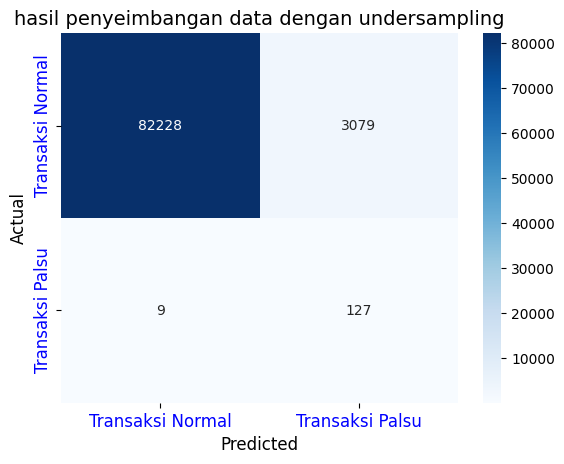

In [32]:
# Confusion Matrix visualisasi
matplotlib.rcParams['text.usetex'] = False

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Transaksi Normal', 'Transaksi Palsu'], yticklabels=['Transaksi Normal', 'Transaksi Palsu'])
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    plt.xticks(fontsize=12, color="blue")
    plt.yticks(fontsize=12, color="blue")
    plt.yticks(fontsize=12, color="blue")

    plt.show()

plot_confusion_matrix(y_test, y_pred_under, "hasil penyeimbangan data dengan undersampling")


* Untuk transaksi normal, terdapat 82.228 (TP) prediksi yang benar dan 3.079 (FP) prediksi yang salah, dengan total 85.307 prediksi yang dibuat.
* Untuk kelas penipuan, terdapat 9 (FN) prediksi yang salah dan 127 (TN) prediksi yang benar, dengan total 136 prediksi yang dibuat.


In [33]:
# Evaluasi kinerja
print("Hasil dengan undersampling:")
print(classification_report(y_test, y_pred_under))

Hasil dengan undersampling:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85307
           1       0.04      0.93      0.08       136

    accuracy                           0.96     85443
   macro avg       0.52      0.95      0.53     85443
weighted avg       1.00      0.96      0.98     85443



Ketika metode undersampling digunakan, nilai recall untuk kelas penipuan tetap sekitar **93%**, yang menunjukkan bahwa **model ini efektif dalam menangkap kelas minoritas**. Namun, nilai **precision** hanya **4%**, yang menunjukkan bahwa model tersebut membuat sejumlah besar prediksi **false positive** untuk transaksi penipuan. Dengan kata lain, meskipun model ini mendeteksi transaksi penipuan dengan benar, model ini memunculkan banyak alarm palsu.

Undersampling telah membantu **mewakili kelas minoritas dengan lebih baik dengan mengurangi contoh dari kelas mayoritas**, sehingga meningkatkan kinerja pada transaksi penipuan. Namun, **metode ini dapat berdampak negatif pada akurasi model secara keseluruhan**, karena mengurangi ukuran total dataset. Penurunan ukuran training set dapat membatasi kemampuan model untuk melakukan generalisasi, yang berarti bahwa meskipun model menjadi lebih berhasil dalam mendeteksi kelas minoritas, **akurasi keseluruhan untuk kelas mayoritas menurun**.


## Method Selection

Dalam studi pendeteksian kecurangan, memilih metode yang tepat sangat penting tergantung pada tujuan kita. Jika tujuan kita adalah **tidak melewatkan kasus kecurangan**, maka nilai **recall** harus diprioritaskan. Khususnya dalam industri seperti perbankan dan asuransi, di mana mencegah kerugian finansial yang besar akibat penipuan adalah hal yang sangat penting, false alarm dapat ditoleransi. Dalam hal ini, hanya alarm palsu yang memerlukan investigasi lebih lanjut yang dapat dianggap sebagai biaya untuk metode yang bertujuan untuk mendeteksi kasus penipuan pada tingkat tertinggi.

Pada set data yang tidak seimbang, model sering kali mengklasifikasikan transaksi yang curang sebagai hal yang normal, yaitu membuat kesalahan **False Negative (FN). Recall digunakan untuk meminimalkan kesalahan ini, menjadikannya salah satu metrik paling penting untuk menangkap transaksi penipuan. Recall dihitung sebagai:

Recall = (TP) / (TP + FN)

Karena ketidakseimbangan data, **akurasi** dan **presisi** tidak selalu memberikan hasil yang benar. Akurasi dapat menyesatkan karena sering kali didominasi oleh transaksi normal, dan presisi dapat berkurang karena kesalahan **False Positive (FP). Oleh karena itu, meningkatkan recall lebih penting untuk menangkap transaksi penipuan.

Di sisi lain, jika prioritas kita adalah untuk **meminimalkan alarm palsu**, kita harus fokus untuk meningkatkan nilai **ketepatan**.
Hal ini sangat penting dalam industri seperti e-commerce, di mana kepuasan pelanggan sangat penting.Alarm palsu dapat menyebabkan hilangnya pelanggan dan pengalaman negatif, sehingga dalam skenario ini, model dan teknik yang lebih sensitif seperti rekayasa fitur dan pengoptimalan ambang batas dapat diterapkan.

Dalam beberapa kasus, tujuannya mungkin untuk mendeteksi penipuan dan mengurangi alarm palsu. Untuk situasi seperti ini, fokus pada metrik seperti **F1-Score**, yang menyeimbangkan antara recall dan presisi, mungkin lebih tepat.Keseimbangan ini memainkan peran penting, terutama dalam operasi asuransi berskala besar.

Dalam proyek kami, karena mencegah kasus penipuan adalah prioritas kami, nilai **recall** menonjol sebagai metrik yang paling penting.
Kami mengamati bahwa nilai recall sekitar **93%** untuk kedua model. Oleh karena itu, dapat dikatakan bahwa model yang menunjukkan kinerja yang lebih seimbang, dengan fokus pada presisi dan F1-Score, harus lebih disukai.Karena nilai F1-Score lebih tinggi pada metode **SMOTE**, metode ini memberikan kinerja yang lebih seimbang pada transaksi penipuan.Dalam hal ini, model **SMOTE-based**, yang mendeteksi kecurangan dengan lebih seimbang dan meminimalisir false positive, dapat menjadi pilihan.


# 5. Model Training


> ## 1. Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Create the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]


Accuracy Score: 0.9995903701883126
Confusion Matrix:
 [[85288    19]
 [   16   120]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.88      0.87       136

    accuracy                           1.00     85443
   macro avg       0.93      0.94      0.94     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9779858679964888


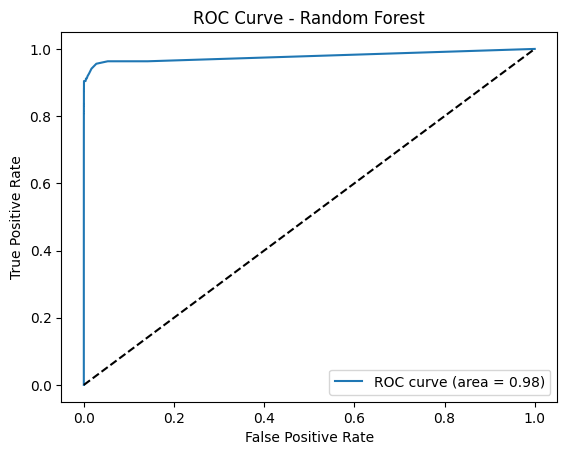

In [35]:
# Confusion Matrix and Classification Report
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# ROC-AUC Score
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("ROC-AUC Score:", auc_rf)

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label="ROC curve (area = %0.2f)" % auc_rf)
plt.plot([0, 1], [0, 1], "k--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()


Hasil yang diperoleh dengan melatih model dengan algoritma Random Forest menunjukkan bahwa model kami cukup berhasil dalam mendeteksi penipuan.

Dengan melihat nilai ROC-AUC, kita dapat melihat bahwa kinerja pemisahan model secara keseluruhan sangat baik.ROC-AUC mengukur perbedaan antara kelas, dan kita dapat mengatakan bahwa model ini memiliki kemampuan yang kuat untuk mendeteksi penipuan. Model kami menunjukkan kinerja yang seimbang dalam mendeteksi kecurangan dan telah mencapai keberhasilan yang baik, terutama dalam menangkap kasus-kasus kecurangan.

Meskipun struktur data yang tidak seimbang dalam set pengujian, kami berhasil mencapai hasil yang efektif dalam membedakan transaksi fraud dan non-fraud.Namun, masih terdapat sedikit tingkat kesalahan pada kelas penipuan (Kelas 1) dengan Recall sebesar 0.88. Hal ini menunjukkan bahwa beberapa transaksi penipuan mungkin terlewatkan. Hal ini mengindikasikan bahwa perbaikan lebih lanjut mungkin diperlukan untuk mendapatkan model yang lebih sensitif.

> ## 2. SVM

In [36]:
# Scaling the data
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train)
X_test_smote = scaler.transform(X_test)

# Define and train the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
svm_model.fit(X_train_smote, y_train)

y_pred = svm_model.predict(X_test_smote)
y_pred_proba = svm_model.predict_proba(X_test_smote)[:, 1]

# Performance metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.9993914071369217
Confusion Matrix:
 [[85299     8]
 [   44    92]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.68      0.78       136

    accuracy                           1.00     85443
   macro avg       0.96      0.84      0.89     85443
weighted avg       1.00      1.00      1.00     85443



ROC-AUC Score: 0.9649915805819673


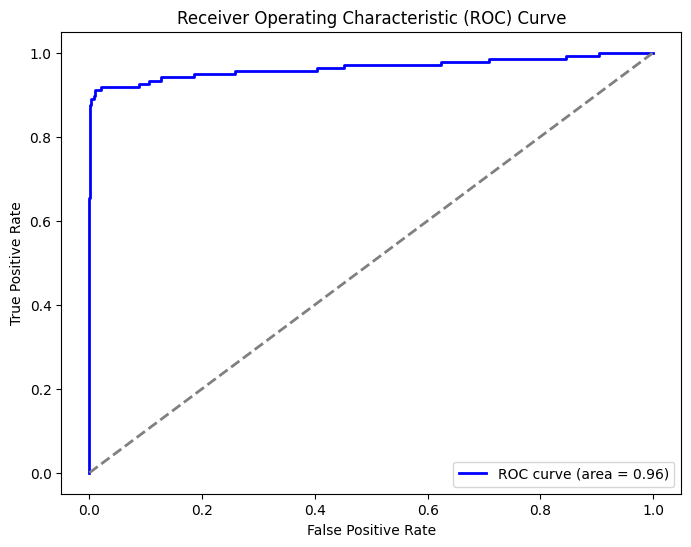

In [37]:
# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Hasil yang diperoleh dengan model SVM menunjukkan tingkat keberhasilan yang tinggi dalam deteksi penipuan. Namun, kami masih dapat mengatakan bahwa model ini masih kurang dalam banyak hal dibandingkan dengan model Random Forest.

Melihat skor ROC-AUC, kami melihat bahwa skor model telah turun menjadi 0,96.Hal ini mengindikasikan bahwa model ini cukup berhasil dalam membedakan antar kelas, tetapi Random Forest secara umum terlihat lebih kuat dalam mendeteksi penipuan.
Meskipun tingkat akurasi model SVM tinggi, nilai recall-nya sebesar 0,68 sangat penting untuk diperhatikan.Hal ini menunjukkan bahwa model ini mampu menangkap kelas penipuan dengan benar (68%).Namun, dibandingkan dengan nilai recall model Random Forest yang sebesar 0.88, kita dapat mengatakan bahwa model SVM mendeteksi transaksi penipuan pada tingkat yang sedikit lebih rendah.Hal ini menunjukkan bahwa risiko mengabaikan beberapa transaksi penipuan lebih tinggi dengan model SVM.

*Meskipun model SVM cukup berhasil dalam mendeteksi kecurangan, kita dapat mengatakan bahwa model Random Forest lebih berhasil dalam membedakan antara kelas dan mendeteksi kecurangan dengan akurasi yang lebih tinggi.


> ## 3. KNN (K-Nearest Neighbors)

In [38]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("New X_train_smote shape:", X_train_smote.shape)
print("New y_train_smote shape:", y_train_smote.shape)


New X_train_smote shape: (398016, 31)
New y_train_smote shape: (398016,)


Accuracy: 0.9977645915990777
Confusion Matrix:
 [[85130   177]
 [   14   122]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.41      0.90      0.56       136

    accuracy                           1.00     85443
   macro avg       0.70      0.95      0.78     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9516610508481821


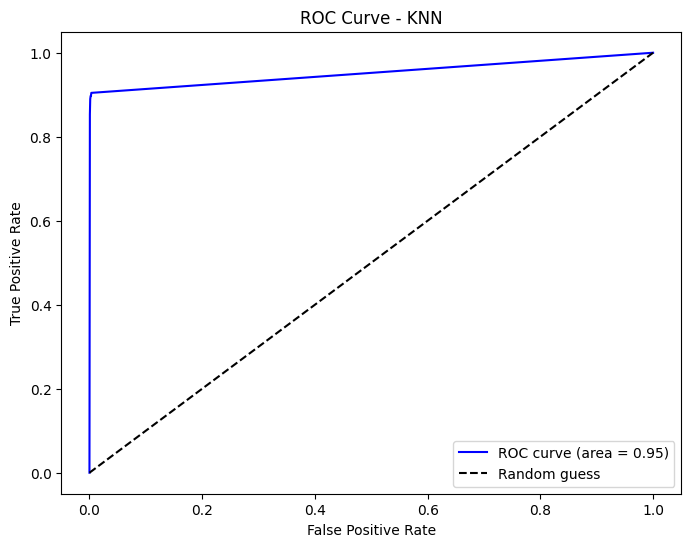

In [39]:
# KNN Model
knn = KNeighborsClassifier(n_neighbors=5, algorithm='auto')  # 'auto', 'ball_tree', 'kd_tree', 'brute' options
knn.fit(X_train_smote, y_train_smote)

# Prediction with test data
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_knn)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
auc_knn = auc(fpr_knn, tpr_knn)

# ROC Curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label="ROC curve (area = %0.2f)" % auc_knn, color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN")
plt.legend(loc="lower right")
plt.show()


Hasil yang diperoleh dengan model KNN (K-Nearest Neighbors) menunjukkan akurasi yang tinggi dalam deteksi penipuan, tetapi ada perbedaan yang signifikan antara kelas.
Namun, setelah analisis lebih lanjut, kami mengamati beberapa hal yang perlu diperhatikan.
Melihat Confusion Matrix, kita dapat melihat bahwa model ini sangat sukses dalam membedakan transaksi normal (Kelas 0) dengan benar, hanya membuat 177 prediksi positif palsu.Namun, model hanya mendeteksi 122 transaksi penipuan (Kelas 1) dengan benar dan membuat 14 prediksi negatif palsu. Hal ini menunjukkan bahwa model memiliki recall yang tinggi (0.90), namun menghasilkan jumlah false positive yang signifikan.

Nilai presisi turun menjadi 0,41, yang berarti hanya 41% dari transaksi yang diklasifikasikan sebagai penipuan yang sebenarnya benar. Hal ini mengindikasikan bahwa model ini rentan terhadap false positive, dan sebagian besar transaksi yang diklasifikasikan sebagai penipuan mungkin tidak benar-benar penipuan. Hal ini menunjukkan bahwa akurasi model dalam mendeteksi kecurangan adalah rendah.Selain itu, F1-Score sebesar 0,56 menunjukkan bahwa kinerja model secara keseluruhan dalam mendeteksi kecurangan tidak memuaskan, terutama mengingat tingginya jumlah false positive.

Nilai ROC-AUC sebesar 0.95 menunjukkan bahwa model ini cukup baik dalam membedakan antar kelas, namun masih berada di bawah model Random Forest (0.98) dan SVM (0.96).

*Kesimpulannya, meskipun model KNN berkinerja cukup baik dalam hal akurasi secara keseluruhan, model ini kurang baik dalam hal presisi dan skor F1. Meskipun model ini memiliki tingkat yang tinggi dalam mendeteksi transaksi penipuan, namun tingkat positif palsu yang tinggi secara signifikan mengurangi keandalan model ini.*



# 6. Conclusion

*Dari hasil analisis kami, kami menentukan bahwa model yang paling cocok adalah Random Forest. Namun, kami masih dapat mengatakan bahwa model ini tidak cukup baik dalam memprediksi penipuan.*

*Saat mengevaluasi situasi ini, penting untuk menunjukkan ketidakseimbangan kelas yang parah dalam dataset. Jumlah transaksi normal secara signifikan lebih tinggi daripada transaksi yang mengandung penipuan. Ketidakseimbangan ini dapat berdampak negatif pada kinerja model dalam membedakan penipuan. Secara keseluruhan, meskipun model kami berkinerja baik, model ini tampaknya kesulitan dalam mendeteksi transaksi penipuan.*
